# Initialise

In [294]:
import astropy.io.fits as pf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.io.fits as pf


def rebin(z_old, pdf_old, zbins):
        # spline
        kwargs_spline = {'s': 0,  # force spline to go through data points
                         'ext': 'zeros',  # ext=0 means extrapolate, =1 means return 0
                         'k': 3,
                        }
        spline = UnivariateSpline(z_old, pdf_old, **kwargs_spline)
        pdf = np.zeros(len(zbins) - 1)
        for i in range(len(zbins) - 1):
            zmin = zbins[i]
            zmax = zbins[i + 1]
            pdf[i] = spline.integral(zmin, zmax) #/ (zmax - zmin)
        return pdf
    
def compute_mean(z0,nz0):
    norm0 = 0.
    mean0 = 0.
    for kk in range(len(z0)):
        norm0+=nz0[kk]
        mean0+=nz0[kk]*z0[kk]
    return mean0/norm0
 
    
def compute_std(z0,nz0):
    norm0 = 0.
    mean0 = 0.
    std = 0.
    for kk in range(len(z0)):
        norm0+=nz0[kk]
        mean0+=nz0[kk]*z0[kk]
    mean0 = mean0/norm0
    norm0 = 0.
    for kk in range(len(z0)):
        norm0+=nz0[kk]
        std+=nz0[kk]*(z0[kk]-mean0)**2
    if std>0.and norm0>0.:
        return  np.sqrt(std/norm0)
    else:
    
        return 0.
    
import pickle 
def save_obj(name, obj):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, protocol = 2)
        f.close()
        
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        mute =  pickle.load(f)
        f.close()
    return mute


class WZ_obj(object):
    def __init__(self,dictionary,info):
        self.sompz= None
        
        self.Nz=dict()
        self.Nz_err=dict()
        self.Nz_mean=dict()
        self.Nz_mean_err=dict()
        self.Nz_std=dict()
        self.Nz_std_err=dict()

        self.sompz_mean=dict()
        self.sompz_std=dict()
        
        self.w_ur = dictionary['Nz']
        self.w_rr = dictionary['bz']
        self.w_dm = None
        self.b_corr = None
        
        self.ntomo = dictionary['Nz'].shape[0]
        self.bins=info['bins']
        self.n_jck = info['n_jck']

        
        self.zmin = info['zmin']
        self.zmax = info['zmax']
        self.z_edges = np.linspace(self.zmin,self.zmax,self.bins+1)
        self.z = 0.5*(self.z_edges[1:]+self.z_edges[:-1])
        self.maskXsigma=None
        
    def shrink_z_interval(self,xd=0,xup=0):
        self.z = self.z[0+xd:len(self.z)-xup]
        self.z_edges = self.z_edges[0+xd:len(self.z_edges)-xup]
        self.bins = self.bins-xd-xup
        
        try:
            self.w_dm = self.w_dm[0+xd:len(self.w_dm)-xup]
        except:
            print('shrinking: nothing to do for w_dm')
        try:
        
            self.sompz = self.sompz[:,0+xd:len(self.z)]
        except:
            print('shrinking: nothing to do for sompz')

   
        
        
    def set_wdm(self,w_dm):
        self.w_dm = w_dm
        
    def set_sompz(self,sompz):
        self.sompz = sompz
        
    def compute_Xsigma_sompz(self,sompz,sigma=2):
        print('computing sompz interval at {0} sigma'.format(sigma))
        mask = []
        try:
            for i in range(len(self.sompz)):
            
                sompz_mean = compute_mean(self.z, self.sompz[i])
                sompz_std = compute_std(self.z, self.sompz[i])
                mask.append((self.z < sompz_mean + sigma*sompz_std) & (self.z > sompz_mean - sigma*sompz_std))
                #normalise sompz
                self.sompz[i] = self.sompz[i]/np.trapz(self.sompz[i][mask[i]], x= self.z[mask[i]])
            self.maskXsigma = mask
        except:
            print ('could not compute X sigma interval')
            
    def compute_nz(self,estimators = ['y1','wdm_br','wdm','wdm_brcorr']):
        
        for method in estimators:
            Nz = np.zeros((self.ntomo,self.bins,self.n_jck+1))
            err = np.zeros((self.ntomo,self.bins))
            try:
            #if 1==1:
                for i in range(self.ntomo):
                    for j in range(self.bins):
                        for k in range(self.n_jck+1):
                            if method == 'y1':
                                Nz[i,j,k] = self.w_ur[i,j,k]
                            elif method == 'wdm':
                                Nz[i,j,k] = self.w_ur[i,j,k]/self.w_dm[j]
                            elif method == 'wdm_br':
                                Nz[i,j,k] = self.w_ur[i,j,k]/(np.sqrt(self.w_rr[i,j,k]*self.w_dm[j]))
                            elif method == 'wdm_brcorr':
                                Nz[i,j,k] = self.w_ur[i,j,k]/(self.b_corr*np.sqrt(self.w_rr[i,j,k]*self.w_dm[j]))

                    # normalise to 2 sigma.

                    Nz[i,:,:]= Nz[i,:,:]/np.trapz(Nz[i,:,0][self.maskXsigma[i]], x = self.z[self.maskXsigma[i]])
                    # compute errors.
                    mute_cov = covariance_jck(Nz[i,:,1:],self.n_jck,'jackknife')
                    err[i,:]=mute_cov['err']
                self.Nz[method] = Nz
                self.Nz_err[method] =err
                
            except:
                print ('Method {0} failed'.format(method))
            self.Nz_estimators=self.Nz.keys()
    def compute_mean_std(self):
        for method in self.Nz.keys():
            mean_arr = np.zeros(self.ntomo)
            sompz_mean_arr = np.zeros(self.ntomo)
            mean_err_arr = np.zeros(self.ntomo)
            std_arr = np.zeros(self.ntomo)
            sompz_std_arr = np.zeros(self.ntomo)
            std_err_arr = np.zeros(self.ntomo)
            for i in range(self.ntomo):
                mean_arr[i]= compute_mean(self.z[self.maskXsigma[i]], self.Nz[method][i,:,0][self.maskXsigma[i]])
                mm= covariance_scalar_jck(compute_mean(self.z[self.maskXsigma[i]], self.Nz[method][i,:,1:][self.maskXsigma[i]]),self.n_jck,'jackknife')
                mean_err_arr[i] = mm['err']
                
                std_arr[i]= compute_std(self.z, self.Nz[method][i,:,0])
                mm= covariance_scalar_jck(compute_std(self.z, self.Nz[method][i,:,1:]),self.n_jck,'jackknife')
                std_err_arr[i] = mm['err']
                
                sompz_mean_arr[i]= compute_mean(self.z[self.maskXsigma[i]], self.sompz[i][self.maskXsigma[i]])
                sompz_std_arr[i]= compute_std(self.z, self.sompz[i])
                
            self.Nz_mean[method] = mean_arr
            self.Nz_mean_err[method] = mean_err_arr
            self.Nz_std[method] = std_arr
            self.Nz_std_err[method] = std_err_arr
            self.sompz_mean[method] = sompz_mean_arr
            self.sompz_std[method] = sompz_std_arr
            
            
    def help_me(self):
        print ('ask Marco :)')

# read 

## read sompz

In [286]:
bbb = np.linspace(0.15, 0.95, 26)
print bbb, len(bbb)

eee = np.linspace(0.1, 1.1, 16)
print eee, len(eee)

zbins_c = bbb[:-1]+ 0.5*(bbb[1]-bbb[0])
print zbins_c, len(zbins_c)

zbinse_c = eee[:-1]+ 0.5*(eee[1]-eee[0])
print zbinse_c, len(zbinse_c)

[0.15  0.182 0.214 0.246 0.278 0.31  0.342 0.374 0.406 0.438 0.47  0.502
 0.534 0.566 0.598 0.63  0.662 0.694 0.726 0.758 0.79  0.822 0.854 0.886
 0.918 0.95 ] 26
[0.1        0.16666667 0.23333333 0.3        0.36666667 0.43333333
 0.5        0.56666667 0.63333333 0.7        0.76666667 0.83333333
 0.9        0.96666667 1.03333333 1.1       ] 16
[0.166 0.198 0.23  0.262 0.294 0.326 0.358 0.39  0.422 0.454 0.486 0.518
 0.55  0.582 0.614 0.646 0.678 0.71  0.742 0.774 0.806 0.838 0.87  0.902
 0.934] 25
[0.13333333 0.2        0.26666667 0.33333333 0.4        0.46666667
 0.53333333 0.6        0.66666667 0.73333333 0.8        0.86666667
 0.93333333 1.         1.06666667] 15


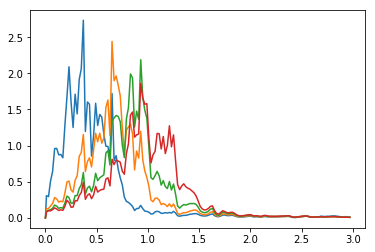

In [287]:
template = pf.open('/global/homes/g/giannini/clustering-z/template_source_nzs_for_mastercat_12_3_19.fits')
#new_template_ = pf.open('/global/cscratch1/sd/jmyles/sompz_buzzard/v0.21/y3_redshift_distributions_v0.21_modal_even.fits')

nz_sompz = pd.DataFrame(template[6].data)

#def rebin(z_old, pdf_old, zbins)
from scipy.interpolate import UnivariateSpline

nz_sompz_25bins = np.empty(shape=(4,25))
nz_sompz_15bins = np.empty(shape=(4,15))
for i in range(4):
    nz_sompz_25bins[i] = rebin(nz_sompz['Z_MID'], nz_sompz['BIN{0}'.format(i+1)], bbb)
    nz_sompz_15bins[i] = rebin(nz_sompz['Z_MID'], nz_sompz['BIN{0}'.format(i+1)], eee)


for i in range(4):
    #integral = np.trapz(nz_sompz['BIN{0}'.format(i)], x = np.linspace(0.15, 0.95-0.033333333333, 24) )
    plt.plot(nz_sompz['Z_MID'], nz_sompz['BIN{0}'.format(i+1)])

## read wz

In [295]:
import sys
sys.path.insert(0, '/global/homes/g/giannini/clustering-z/WZ_utils/')
from covariance_routines import *
from load_routines import *



n_jck=100
gamma = 1
zmin=0.15
zmax=0.95
bins = 25
ang_bins = 8

info ={'n_jck':n_jck,'zmin':zmin,'zmax':zmax,'bins' : bins}

path_base = '/global/cscratch1/sd/mgatti/clustering_z/mastercat_12_3_19_'

to_read = ['rmg_R_w/',
           'rmg_R/',
           'rmg_w/',
           'rmg/',
           'rmg_R_w_1500_5000/']


measured_wz = load_obj('/global/homes/m/mgatti/clustering-z/WZ_cosmosis1')

runs_data = dict()
for ff in to_read:
    try:
        dictionary = read_results_fast(path_base+ff,n_jck,gamma,ang_bins)
        method = ff.strip('/')
        print (method)
        runs_data[method]  = WZ_obj(dictionary,info)
        runs_data[method].set_wdm(np.hstack([measured_wz['th_correction'],0]))
        runs_data[method].set_sompz(nz_sompz_25bins)
        runs_data[method].shrink_z_interval(xd=0,xup=1)
        runs_data[method].compute_Xsigma_sompz(nz_sompz_25bins)
        runs_data[method].compute_nz(estimators = ['y1','wdm_br','wdm'])
        #runs_data[method].compute_nz(estimators = ['y1','wdm_br','wdm','wdm_brcorr'])
        runs_data[method].compute_mean_std()
    except:
        print (path_base+ff)

n_jck=100
gamma = 1
zmin=0.1
zmax=1.1
bins = 15
ang_bins = 8

info ={'n_jck':n_jck,'zmin':zmin,'zmax':zmax,'bins' : bins}
     
to_read = ['eboss_R_w/',
           'eboss_R/',
           'eboss_w/',
           'eboss/',
           'eboss_R_w_1500_5000/',
           'eboss_R_w_25_rm/',
           'eboss_R_w_random_wrong/']     
        
for ff in to_read:
    try:
        dictionary = read_results_fast(path_base+ff,n_jck,gamma,ang_bins)
        method = ff.strip('/')
        print (method)
        runs_data[method]  = WZ_obj(dictionary,info)
        runs_data[method].set_wdm(np.hstack([measured_wz['th_correction_eboss'],0]))
        runs_data[method].set_sompz(nz_sompz_15bins)
        runs_data[method].shrink_z_interval(xd=0,xup=1)
        runs_data[method].compute_Xsigma_sompz(nz_sompz_15bins)
        runs_data[method].compute_nz(estimators = ['y1','wdm_br','wdm'])
        #runs_data[method].compute_nz(estimators = ['y1','wdm_br','wdm','wdm_brcorr'])
        runs_data[method].compute_mean_std()
    except:
        print (path_base+ff)

print ('done')
'''
to print the mean:
runs[method].Nz_mean[estimator][tomobin],runs[method].Nz_mean_err[estimator][tomobin]

'''

rmg_R_w
computing sompz interval at 2 sigma
rmg_R
computing sompz interval at 2 sigma
rmg_w
computing sompz interval at 2 sigma
rmg
computing sompz interval at 2 sigma
rmg_R_w_1500_5000
computing sompz interval at 2 sigma
eboss_R_w
computing sompz interval at 2 sigma
eboss_R
computing sompz interval at 2 sigma
eboss_w
computing sompz interval at 2 sigma
eboss
computing sompz interval at 2 sigma
eboss_R_w_1500_5000
computing sompz interval at 2 sigma
eboss_R_w_25_rm
computing sompz interval at 2 sigma
/global/cscratch1/sd/mgatti/clustering_z/mastercat_12_3_19_eboss_R_w_random_wrong/
done


'\nto print the mean:\nruns[method].Nz_mean[estimator][tomobin],runs[method].Nz_mean_err[estimator][tomobin]\n\n'

In [42]:
measured_wz = load_obj('/global/homes/m/mgatti/clustering-z/WZ_cosmosis1')

# mean

In [439]:
runs_data['rmg'].Nz.keys()

['y1', 'wdm_br', 'wdm']

In [443]:
for i in range(4):
    print '\n'
    print 'BIN ', i 
    for est in ['wdm_br']:#runs_data['rmg'].Nz.keys():
        print '------'
        print est
        print '------'

        for method in ['rmg_R_w', 'eboss_R_w']:#runs_data.keys():
            
            print method
            print '-'
            print 'shift        {0:2.3f}'.format(runs_data[method].Nz_mean[est][i]-runs_data[method].sompz_mean[est][i])
            print 'mean         {0:2.3f}'.format(runs_data[method].Nz_mean[est][i])
            print 'meanerr      {0:2.4f}'.format(runs_data[method].Nz_mean_err[est][i])
            print 'std          {0:2.3f}'.format(runs_data[method].Nz_std[est][i])
            print 




BIN  0
------
wdm_br
------
rmg_R_w
-
shift        0.014
mean         0.437
meanerr      0.0020
std          0.142

eboss_R_w
-
shift        0.023
mean         0.435
meanerr      0.0072
std          0.241



BIN  1
------
wdm_br
------
rmg_R_w
-
shift        0.047
mean         0.657
meanerr      0.0017
std          0.162

eboss_R_w
-
shift        0.069
mean         0.703
meanerr      0.0087
std          0.192



BIN  2
------
wdm_br
------
rmg_R_w
-
shift        0.060
mean         0.747
meanerr      0.0023
std          0.139

eboss_R_w
-
shift        0.050
mean         0.802
meanerr      0.0094
std          0.167



BIN  3
------
wdm_br
------
rmg_R_w
-
shift        0.069
mean         0.758
meanerr      0.0069
std          0.136

eboss_R_w
-
shift        0.088
mean         0.864
meanerr      0.0152
std          0.168



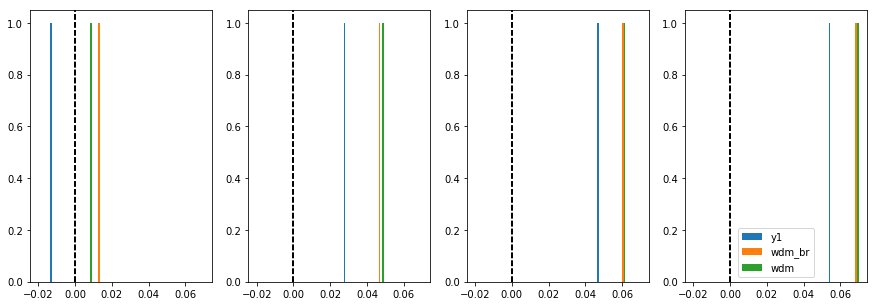

In [418]:
fig, ax = plt.subplots(1, 4, figsize = (15, 5))
for i in range(4):
    for est in runs_data['rmg'].Nz.keys():
        ax[i].hist(runs_data['rmg_R_w'].Nz_mean[est][i]-runs_data['rmg_R_w'].sompz_mean[est][i], bins = np.linspace(-0.02, 0.07, 100), label = '{0}'.format(est))
        ax[i].axvline(linestyle = '--', color = 'black')
plt.legend()

# Plots 

### rm

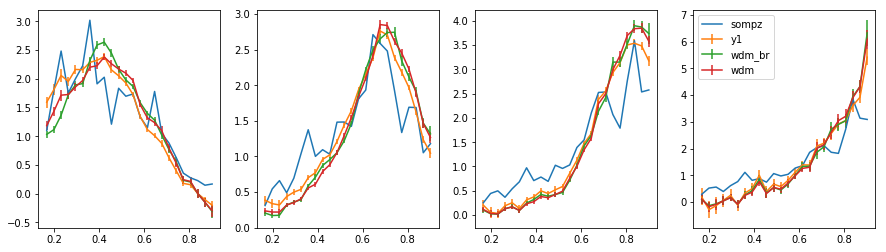

In [327]:
fig, ax = plt.subplots(1, 4, figsize=(15,4))

for i in range(4):
    z = runs_data['rmg_R_w'].z
    ax[i].errorbar(z, runs_data['rmg_R_w'].sompz[i], label='sompz')         
    for est in runs_data['rmg_R_w'].Nz_mean.keys():
        ax[i].errorbar(z, runs_data['rmg_R_w'].Nz[est][i,:,0], runs_data['rmg_R_w'].Nz_err[est][i,:], label='{0}'.format(est))         

plt.legend()

### eboss

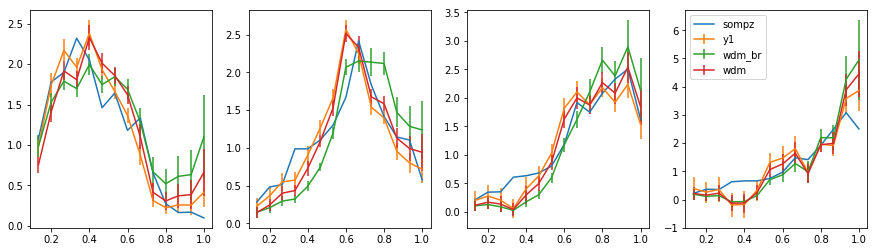

In [328]:
fig, ax = plt.subplots(1, 4, figsize=(15,4))

for i in range(4):
    z = runs_data['eboss_R_w'].z
    ax[i].errorbar(z, runs_data['eboss_R_w'].sompz[i], label='sompz')         
    for est in runs_data['eboss_R_w'].Nz_mean.keys():
        ax[i].errorbar(z, runs_data['eboss_R_w'].Nz[est][i,:,0], runs_data['eboss_R_w'].Nz_err[est][i,:], label='{0}'.format(est))         

plt.legend()

### comparison rm vs eboss

In [331]:
runs_data['rmg_R_w'].sompz[i].shape

(24,)

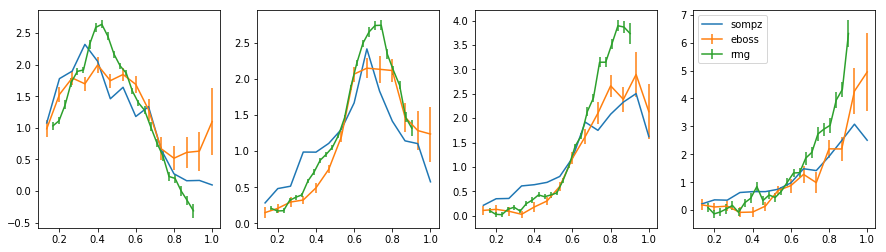

In [332]:
fig, ax = plt.subplots(1, 4, figsize=(15,4))

for i in range(4):
    z = runs_data['eboss_R_w'].z
    ax[i].errorbar(z, runs_data['eboss_R_w'].sompz[i], label='sompz')         
    ax[i].errorbar(z, runs_data['eboss_R_w'].Nz['wdm_br'][i,:,0], runs_data['eboss_R_w'].Nz_err['wdm_br'][i,:], label='eboss')         
    z = runs_data['rmg_R_w'].z
    ax[i].errorbar(z, runs_data['rmg_R_w'].Nz['wdm_br'][i,:,0], runs_data['rmg_R_w'].Nz_err['wdm_br'][i,:], label='rmg')         

plt.legend()

In [345]:
runs_data['eboss_R_w'].Nz['y1'].shape

(4, 14, 101)

In [347]:
for i in range(len(runs_data['eboss_R_w'].Nz['y1'])):
    print i
    z = runs_data['eboss_R_w'].z
    print 'eboss  {0:2.3f} {1:2.3f}'.format(min(z[runs_data['eboss_R_w'].maskXsigma[i]]),  max(z[runs_data['eboss_R_w'].maskXsigma[i]]))
    z = runs_data['rmg_R_w'].z
    print 'rmg    {0:2.3f} {1:2.3f}'.format(min(z[runs_data['rmg_R_w'].maskXsigma[i]]), max(z[runs_data['rmg_R_w'].maskXsigma[i]]))


0
eboss  0.133 0.800
rmg    0.166 0.774
1
eboss  0.200 1.000
rmg    0.230 0.902
2
eboss  0.333 1.000
rmg    0.294 0.902
3
eboss  0.333 1.000
rmg    0.294 0.902


### eboss 25 bins 

In [348]:
# fig, ax = plt.subplots(1, 4, figsize=(15,4))
# meanz_eboss = dict()


# for i in range(4):
#     print 'bin ', i

#     int_sompz = np.trapz(nz_sompz_25bins[i][:24][mask_rm[i]], x = zbins_c[:24][mask_rm[i]])
#     int_sompz15 = np.trapz(nz_sompz_15bins[i][:14], x = zbinse_c[:14])
#     a = 1.#(int_sompz)
#     print a 
#     ax[i].plot(zbins_c[:24][mask_rm[i]], nz_sompz_25bins[i][:24][mask_rm[i]]/int_sompz, label = 'sompz')
#     mask_eboss[i]
#     ax[i].errorbar(zbins_c[:24][mask_rm[i]], runs[5]['Nz'][i,:24,0][mask_rm[i]]*a/(np.sqrt(runs[5]['bz'][i,:24,0][mask_rm[i]]*measured_wz['th_correction'][mask_rm[i]])*integral[5][i]), cov_jck_rm[5][i]['y3']['err'][:24][mask_rm[i]]*a/(np.sqrt(measured_wz['th_correction'][mask_rm[i]])*integral[5][i]), label = 'eboss 24 bins')
#     #print zbinse_c[mask_eboss[i]]
#     ax[i].errorbar(zbinse_c[mask_eboss[i]], runs_eboss[0]['Nz'][i,:14,0][mask_eboss[i]]*a/(np.sqrt(runs_eboss[0]['bz'][i,:14,0][mask_eboss[i]]*measured_wz['th_correction_eboss'][mask_eboss[i]])*int_eboss[0][i]), cov_jck_eboss[0][i]['y3']['err'][:14][mask_eboss[i]]*a/(np.sqrt(measured_wz['th_correction_eboss'][mask_eboss[i]])*int_eboss[0][i]), label = 'eboss 14 bins')
    
#     ax[i].errorbar(zbins_c[:24][mask_rm[i]], runs[0]['Nz'][i,:24,0][mask_rm[i]]/(np.sqrt(runs[0]['bz'][i,:24,0][mask_rm[i]]*measured_wz['th_correction'][mask_rm[i]])*integral[0][i]), cov_jck_rm[0][i]['y3']['err'][:24][mask_rm[i]]/(np.sqrt(measured_wz['th_correction'][mask_rm[i]])*integral[0][i]), label = 'redmagic')
#     #print zbins_c[:24][mask_rm[i]]
    
# plt.legend()

In [97]:
for i in range(4):
    print '\nbin ', i
    #print 'meanz  ', meanz[i]['y3mean']
    print '--rm '
    print 'meanz2s', meanz[i]['y3mean_2s']
    print 'shifts ', meanz[i]['y3mean_2s']-meanz[i]['sompz_mean2s']
    print '--eboss'
    print 'meanz2s', meanz_eboss[i]['y3mean_2s']
    print 'shifts ', meanz_eboss[i]['y3mean_2s']-meanz_eboss[i]['sompz_mean2s']


bin  0
--rm 
meanz2s 0.4292798755103028
shifts  0.016062783921270973
--eboss
meanz2s 0.46925184968095757
shifts  0.04729503045863609

bin  1
--rm 
meanz2s 0.672324468019545
shifts  0.02999567401815728
--eboss
meanz2s 0.7184289345447575
shifts  0.056771799499124365

bin  2
--rm 
meanz2s 0.7649877928655746
shifts  0.03091731823795152
--eboss
meanz2s 0.8076087678645915
shifts  0.023549084429493106

bin  3
--rm 
meanz2s 0.7843996745608345
shifts  0.030355123200514034
--eboss
meanz2s 0.8633443170092567
shifts  0.03655799796130366


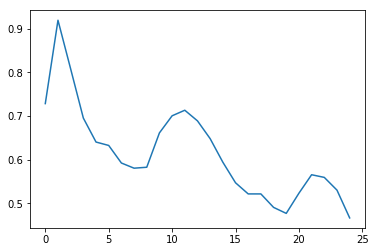

In [211]:
plt.plot(corr_sims_hr)

### small vs large scales

In [349]:
runs_data.keys()

['rmg_R_w',
 'rmg_R',
 'rmg_w',
 'eboss_R_w_1500_5000',
 'eboss_w',
 'eboss_R',
 'rmg_R_w_1500_5000',
 'eboss_R_w',
 'rmg',
 'eboss',
 'eboss_R_w_25_rm']

In [352]:
runs_data['rmg_R_w_1500_5000'].Nz.keys()

['y1', 'wdm_br', 'wdm']

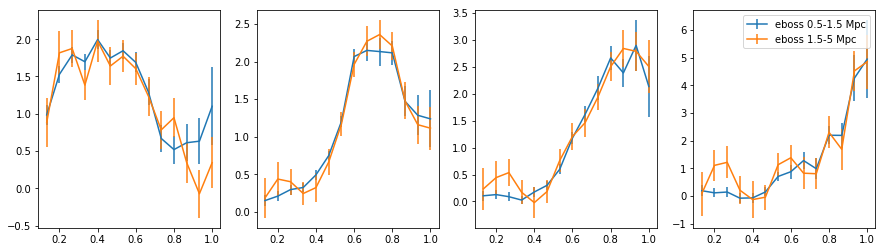

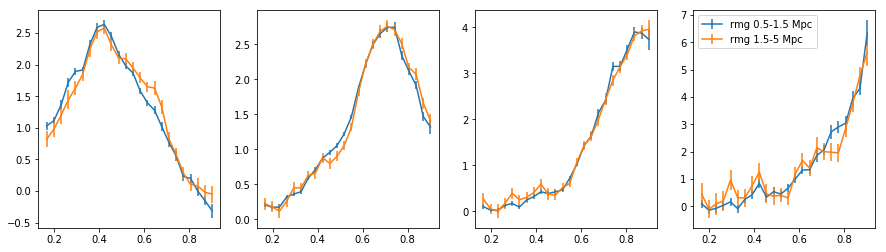

In [356]:
fig, ax = plt.subplots(1, 4, figsize=(15,4))

for i in range(4):
    z = runs_data['eboss_R_w'].z
    #ax[i].errorbar(z, runs_data['eboss_R_w'].sompz[i], label='sompz')         
    ax[i].errorbar(z, runs_data['eboss_R_w'].Nz['wdm_br'][i,:,0], runs_data['eboss_R_w'].Nz_err['wdm_br'][i,:], label='eboss 0.5-1.5 Mpc')         
    ax[i].errorbar(z, runs_data['eboss_R_w_1500_5000'].Nz['wdm_br'][i,:,0], runs_data['eboss_R_w_1500_5000'].Nz_err['wdm_br'][i,:], label='eboss 1.5-5 Mpc')         

plt.legend()

fig, ax = plt.subplots(1, 4, figsize=(15,4))

for i in range(4):
    z = runs_data['rmg_R_w'].z
    #ax[i].errorbar(z, runs_data['rmg_R_w'].sompz[i], label='sompz')         
    ax[i].errorbar(z, runs_data['rmg_R_w'].Nz['wdm_br'][i,:,0], runs_data['rmg_R_w'].Nz_err['wdm_br'][i,:], label='rmg 0.5-1.5 Mpc')         
    ax[i].errorbar(z, runs_data['rmg_R_w_1500_5000'].Nz['wdm_br'][i,:,0], runs_data['rmg_R_w_1500_5000'].Nz_err['wdm_br'][i,:], label='rmg 1.5-5 Mpc')         

plt.legend()

## test weights and response function

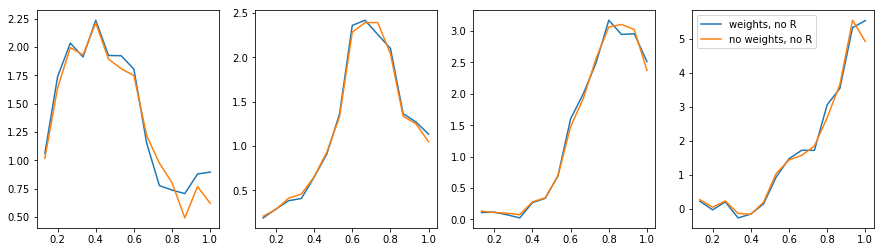

In [246]:
fig, ax = plt.subplots(1, 4, figsize=(15,4))
for i in range(4):
    #ax[i].plot(zbinse_c, runs_eboss[0]['Nz'][i,:,0][:14]/(measured_wz['th_correction_eboss']**2*int_eboss[0][i]), label = 'weights, R no b')
    #ax[i].plot(zbins_c, runs_eboss[0]['Nz'][i,:,0][:14]/(inte_ebossgral[0][i]), label = 'weights, R no b')
    
    #ax[i].plot(zbinse_c, runs_eboss[0]['Nz'][i,:14,0]/(np.sqrt(runs_eboss[0]['bz'][i,:14,0]*measured_wz['th_correction_eboss'])*int_eboss[0][i]), label = 'weights, R')
    ax[i].plot(zbinse_c, runs_eboss[1]['Nz'][i,:14,0]/(np.sqrt(runs_eboss[1]['bz'][i,:14,0]*measured_wz['th_correction_eboss'])*int_eboss[1][i]), label = 'weights, no R')
    #ax[i].plot(zbinse_c, runs_eboss[2]['Nz'][i,:14,0]/(np.sqrt(runs_eboss[2]['bz'][i,:14,0]*measured_wz['th_correction_eboss'])*int_eboss[2][i]), label = 'no weights, R')
    ax[i].plot(zbinse_c, runs_eboss[3]['Nz'][i,:14,0]/(np.sqrt(runs_eboss[3]['bz'][i,:14,0]*measured_wz['th_correction_eboss'])*int_eboss[3][i]), label = 'no weights, no R')

ax[3].legend()


In [ ]:
for i in range(4):
    print i 
    miao = dict()
    print 'w r ', compute_std(zbinse_c[:14], runs[0]['Nz'][i,:14,0]/(np.sqrt(runs[0]['bz'][i,:14,0]*measured_wz['th_correction_eboss'])))
    #print miao['y3mean'], miao['y3std']
    mask = (zbinse_c[:14] < (miao['y3mean']+2*miao['y3std'])) &  (zbins_c[:24] > (miao['y3mean']-2*miao['y3std']))
    #print mask, len(mask)
    miao['y3mean_2s'] = compute_mean(zbins_c[:24][mask], (runs[0]['Nz'][i,:24,0]/(np.sqrt(runs[0]['bz'][i,:24,0]*measured_wz['th_correction'])))[mask])
    b = np.zeros((100))
    for j in range(100):
        b[j] = compute_mean(zbins_c[:24][mask], (runs[0]['Nz'][i,:24,j+1]/(np.sqrt(runs[0]['bz'][i,:24,j+1]*measured_wz['th_correction'])))[mask]) 
    miao['y3mean_2s_err'] = covariance_scalar_jck(b,100,'jackknife')
    

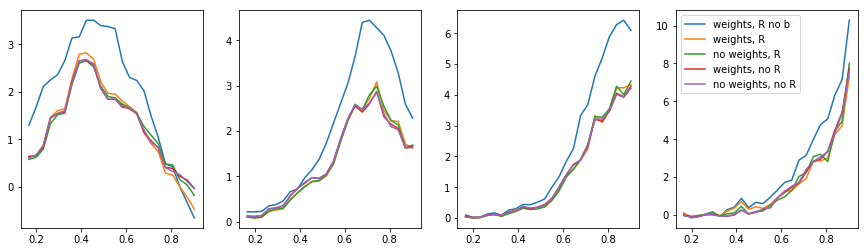

In [178]:
fig, ax = plt.subplots(1, 4, figsize=(15,4))
for i in range(4):
    ax[i].plot(zbins_c[:24], runs[0]['Nz'][i,:,0][:24]/(measured_wz['th_correction']**2*integral[0][i]), label = 'weights, R no b')
    #ax[i].plot(zbins_c[:24], runs[0]['Nz'][i,:,0][:24]/(integral[0][i]), label = 'weights, R no b')
    
    ax[i].plot(zbins_c[:24], runs[0]['Nz'][i,:,0][:24]/(runs[0]['bz'][i,:24,0]*measured_wz['th_correction']*integral[0][i]), label = 'weights, R')
    ax[i].plot(zbins_c[:24], runs[1]['Nz'][i,:,0][:24]/(runs[1]['bz'][i,:24,0]*measured_wz['th_correction']*integral[1][i]), label = 'no weights, R')
    ax[i].plot(zbins_c[:24], runs[2]['Nz'][i,:,0][:24]/(runs[2]['bz'][i,:24,0]*measured_wz['th_correction']*integral[2][i]), label = 'weights, no R')
    ax[i].plot(zbins_c[:24], runs[3]['Nz'][i,:,0][:24]/(runs[3]['bz'][i,:24,0]*measured_wz['th_correction']*integral[3][i]), label = 'no weights, no R')

ax[3].legend()


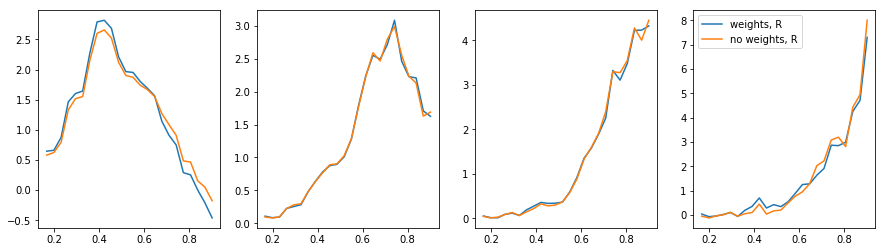

In [173]:
fig, ax = plt.subplots(1, 4, figsize=(15,4))
for i in range(4):
    ax[i].plot(zbins_c[:24], runs[0]['Nz'][i,:,0][:24]/(runs[0]['bz'][i,:24,0]*measured_wz['th_correction']*integral[0][i]), label = 'weights, R')
    ax[i].plot(zbins_c[:24], runs[1]['Nz'][i,:,0][:24]/(runs[1]['bz'][i,:24,0]*measured_wz['th_correction']*integral[1][i]), label = 'no weights, R')

ax[3].legend()


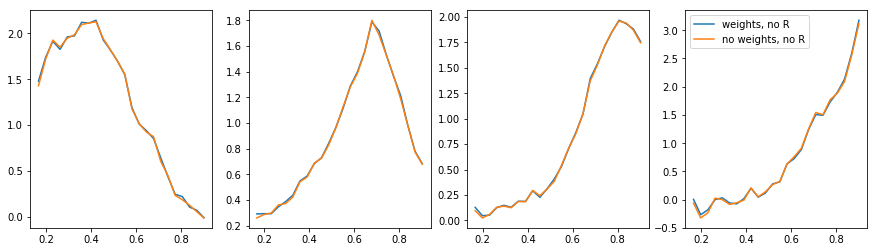

In [167]:
fig, ax = plt.subplots(1, 4, figsize=(15,4))
for i in range(4):
    ax[i].plot(zbins_c[:24], runs[2]['Nz'][i,:,0][:24]/integral[2][i], label = 'weights, no R')
    ax[i].plot(zbins_c[:24], runs[3]['Nz'][i,:,0][:24]/integral[3][i], label = 'no weights, no R')

ax[3].legend()


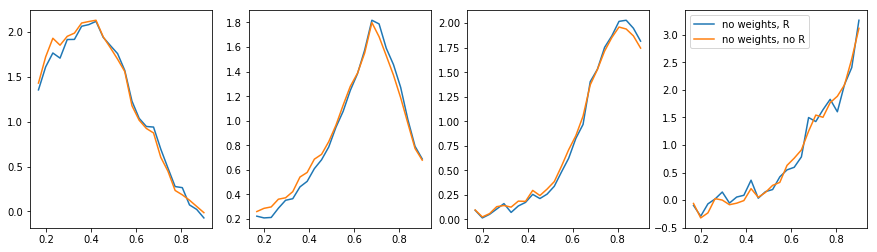

In [166]:
fig, ax = plt.subplots(1, 4, figsize=(15,4))
for i in range(4):
    ax[i].plot(zbins_c[:24], runs[1]['Nz'][i,:,0][:24]/integral[1][i], label = 'no weights, R')
    ax[i].plot(zbins_c[:24], runs[3]['Nz'][i,:,0][:24]/integral[3][i], label = 'no weights, no R')

ax[3].legend()


In [193]:
integral.shape

(4, 4)

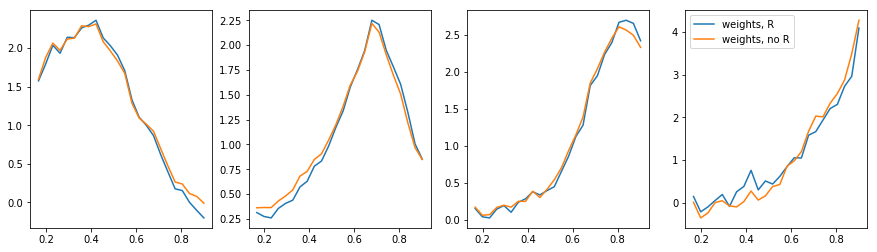

In [194]:
fig, ax = plt.subplots(1, 4, figsize=(15,4))
for i in range(4):
    ax[i].plot(zbins_c[:24], runs[0]['Nz'][i,:,0][:24]/integral[0][i], label = 'weights, R')
    ax[i].plot(zbins_c[:24], runs[2]['Nz'][i,:,0][:24]/integral[2][i], label = 'weights, no R')
    
ax[3].legend()


# data vs simulations

In [254]:
'''
x redamagic *************************
systematics [ type_sims] [ tomo bin] [estimator] [key]
type_sims =0 -> spec z ref
type_sims =1 -> rmg z ref

estimator:
'bias_wl', 'bias_wl_full', 'w_br', 'w_br_bl', 'true'

x eboss **************************
systematics_eboss [ type_sims] [ tomo bin] [estimator]  [key]
type_sims =0 -> spec z ref default

estimator:
'bias_wl', 'bias_wl_full', 'w_br', 'w_br_bl', 'true'

'''

"\nx redamagic *************************\nsystematics [ type_sims] [ tomo bin] [estimator] [key]\ntype_sims =0 -> spec z ref\ntype_sims =1 -> rmg z ref\n\nestimator:\n'bias_wl', 'bias_wl_full', 'w_br', 'w_br_bl', 'true'\n\nx eboss **************************\nsystematics_eboss [ type_sims] [ tomo bin] [estimator]  [key]\ntype_sims =0 -> spec z ref default\n\nestimator:\n'bias_wl', 'bias_wl_full', 'w_br', 'w_br_bl', 'true'\n\n"

In [248]:
systematics = load_obj('./systematics')
systematics_eboss = load_obj('./systematics_eboss')

In [422]:
systematics[0][0].keys()

['bias_wl',
 'bias_rmg',
 'bias_wl_full',
 'w_br',
 'w_br_bl',
 'bias_rmg_full',
 'br',
 'y1',
 'true']

In [429]:
systematics[0][i]['y1'].keys()

['std',
 'std_err',
 'truth_full',
 'mean_err',
 'final_jck',
 'final_full_jck',
 'mask',
 'final_full',
 'final',
 'z_ref',
 'dz',
 'truth',
 'dz_n',
 'mean']

In [ ]:
# import sys
# sys.path.insert(0, '/global/homes/g/giannini/clustering-z/WZ_utils/')
# from covariance_routines import *
# from load_routines import *



n_jck=100
gamma = 1
zmin=0.15
zmax=0.95
bins = 25
ang_bins = 8

info ={'n_jck':n_jck,'zmin':zmin,'zmax':zmax,'bins' : bins}

path_base = '/global/cscratch1/sd/mgatti/clustering_z/mastercat_12_3_19_'

to_read = ['rmg_R_w/',
           'rmg_R/',
           'rmg_w/',
           'rmg/',
           'rmg_R_w_1500_5000/']


measured_wz = load_obj('/global/homes/m/mgatti/clustering-z/WZ_cosmosis1')

runs_data = dict()
for ff in to_read:
    try:
        dictionary = read_results_fast(path_base+ff,n_jck,gamma,ang_bins)
        method = ff.strip('/')
        print (method)
        runs_data[method]  = WZ_obj(dictionary,info)
        runs_data[method].set_wdm(np.hstack([measured_wz['th_correction'],0]))
        runs_data[method].set_sompz(nz_sompz_25bins)
        runs_data[method].shrink_z_interval(xd=0,xup=1)
        runs_data[method].compute_Xsigma_sompz(nz_sompz_25bins)
        runs_data[method].compute_nz(estimators = ['y1','wdm_br','wdm'])
        #runs_data[method].compute_nz(estimators = ['y1','wdm_br','wdm','wdm_brcorr'])
        runs_data[method].compute_mean_std()
    except:
        print (path_base+ff)

n_jck=100
gamma = 1
zmin=0.1
zmax=1.1
bins = 15
ang_bins = 8

info ={'n_jck':n_jck,'zmin':zmin,'zmax':zmax,'bins' : bins}
     
to_read = ['eboss_R_w/',
           'eboss_R/',
           'eboss_w/',
           'eboss/',
           'eboss_R_w_1500_5000/',
           'eboss_R_w_25_rm/',
           'eboss_R_w_random_wrong/']     
        
for ff in to_read:
    try:
        dictionary = read_results_fast(path_base+ff,n_jck,gamma,ang_bins)
        method = ff.strip('/')
        print (method)
        runs_data[method]  = WZ_obj(dictionary,info)
        runs_data[method].set_wdm(np.hstack([measured_wz['th_correction_eboss'],0]))
        runs_data[method].set_sompz(nz_sompz_15bins)
        runs_data[method].shrink_z_interval(xd=0,xup=1)
        runs_data[method].compute_Xsigma_sompz(nz_sompz_15bins)
        runs_data[method].compute_nz(estimators = ['y1','wdm_br','wdm'])
        #runs_data[method].compute_nz(estimators = ['y1','wdm_br','wdm','wdm_brcorr'])
        runs_data[method].compute_mean_std()
    except:
        print (path_base+ff)

print ('done')
'''
to print the mean:
runs[method].Nz_mean[estimator][tomobin],runs[method].Nz_mean_err[estimator][tomobin]

'''

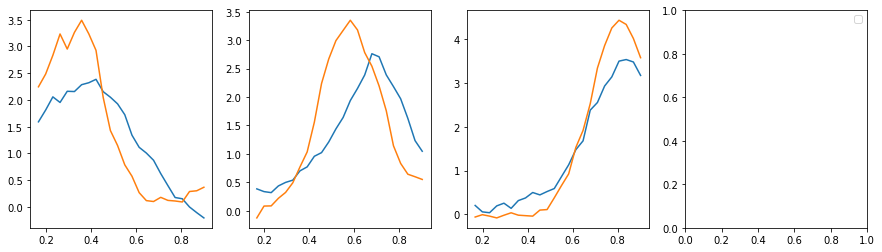

In [438]:
fig, ax = plt.subplots(1, 4, figsize=(15,4))

for i in range(3):
    ax[i].plot(runs_data['rmg'].z, runs_data['rmg_R_w'].Nz['y1'][i,:,0], label = 'data')
    ax[i].plot(runs_data['rmg'].z, systematics[0][i]['y1']['final_full'][:24], label = 'sims')
plt.legend()

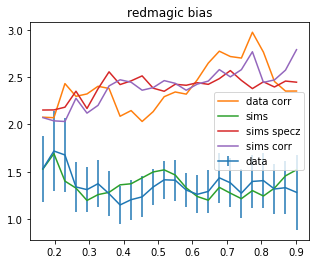

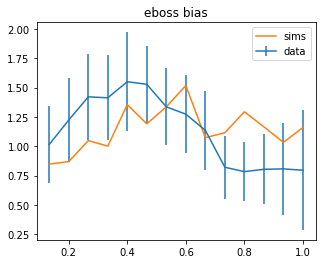

In [323]:
fig, ax = plt.subplots(figsize=(5,4))

intt = np.trapz(np.sqrt(runs[0]['bz'][0,:24,0]/measured_wz['th_correction']), x = zbins_c[:24])
ntt = np.trapz(measured_wz['bias_rm'][0][:,0], x = zbins_c[:24])
plt.errorbar(zbins_c[:24], np.sqrt(runs[0]['bz'][0,:24,0]/measured_wz['th_correction'])/intt, np.sqrt(cov_bias_rm[0][0]['err']/measured_wz['th_correction'])/intt, label = 'data')
plt.plot(zbins_c[:24], np.sqrt(runs[0]['bz'][0,:24,0]/measured_wz['th_correction'])/intt/corr_sims[:24], label = 'data corr')

plt.plot(zbins_c[:24], measured_wz['bias_rm'][0][:,0]/ntt, label = 'sims')
plt.plot(zbins_c[:24], measured_wz['bias_rm_specz'][0][:,0]/ntt, label = 'sims specz')
plt.plot(zbins_c[:24], measured_wz['bias_rm'][0][:,0]/corr_sims[:24]/ntt, label = 'sims corr')






#plt.suptitle('small vs large scales')
plt.title('redmagic bias')
plt.legend()



fig, ax = plt.subplots( figsize=(5,4))



intt = np.trapz(np.sqrt(runs_eboss[0]['bz'][0,:14,0]/measured_wz['th_correction_eboss']), x = zbinse_c[:14])
ntt = np.trapz(measured_wz['bias_eboss'][0][:,0], x = zbinse_c[:14])
plt.errorbar(zbinse_c[:14], np.sqrt(runs_eboss[0]['bz'][0,:14,0]/measured_wz['th_correction_eboss'])/intt, np.sqrt(cov_bias_eboss[0][0]['err']/measured_wz['th_correction_eboss'])/intt, label = 'data')
plt.plot(zbinse_c[:14], measured_wz['bias_eboss'][0][:,0]/ntt, label = 'sims')
#plt.suptitle('small vs large scales')
plt.title('eboss bias')
plt.legend()

In [60]:
1

1

/global/u2/m/mgatti/.conda/envs/myenv_up/lib/python2.7/site-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/global/u2/m/mgatti/.conda/envs/myenv_up/lib/python2.7/site-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/global/u2/m/mgatti/.conda/envs/myenv_up/lib/python2.7/site-packages/ipykernel_launcher.py:47: VisibleDeprecationW

(0.098, 0.29800000000000004)

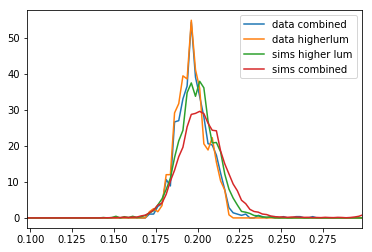

In [217]:
import h5py
import numpy as np
xx = 1
mastercat_v = '12_3_19'

path_mastercat = '/project/projectdirs/des/www/y3_cats/Y3_mastercat_'+mastercat_v+'.h5'
path_to_save = '/global/cscratch1/sd/mgatti/clustering_z/data/'


mastercat = h5py.File(path_mastercat,'r')
zspec_mst = np.array(mastercat['catalog']['redmagic']['combined_sample_fid']['zspec'])
zrmg_mst = np.array(mastercat['catalog']['redmagic']['combined_sample_fid']['zredmagic'])
zrmg_mst= (zrmg_mst[zspec_mst>-1])
zspec_mst = (zspec_mst[zspec_mst>-1])

edg = np.linspace(0.15,0.95,26)
cntr = 0.5*(edg[1:]+edg[:-1])
edg_hr = np.linspace(0.,1.5,601)
cntr_hr = 0.5*(edg_hr[1:]+edg_hr[:-1])
corr = np.zeros(25)
for i in range(25):
    mask1 = (zrmg_mst>edg[i]) & ((zrmg_mst<edg[i+1]))
    #mask1 = (zspec_mst>edg[i]) & ((zspec_mst<edg[i+1]))
    nzh,_ = np.histogram(zspec_mst[mask1],bins=edg_hr,normed=True)
    nzh_u,_ = np.histogram(np.linspace(edg[i],edg[i+1],50000),bins=edg_hr,normed=True)
    if i==xx:
        plt.plot(cntr_hr,nzh,label='data combined')
    corr[i] = np.trapz(nzh**2,cntr_hr)/np.trapz(nzh_u**2,cntr_hr)#
#corr = np.sqrt(corr)
#plt.plot(cntr,corr)



zspec_mst = np.array(mastercat['catalog']['redmagic']['higherlum']['zspec'])
zrmg_mst = np.array(mastercat['catalog']['redmagic']['higherlum']['zredmagic'])
zrmg_mst= (zrmg_mst[zspec_mst>-1])
zspec_mst = (zspec_mst[zspec_mst>-1])

edg = np.linspace(0.15,0.95,26)
cntr = 0.5*(edg[1:]+edg[:-1])
edg_hr = np.linspace(0.,1.5,601)
cntr_hr = 0.5*(edg_hr[1:]+edg_hr[:-1])
corr = np.zeros(25)
for i in range(25):
    mask1 = (zrmg_mst>edg[i]) & ((zrmg_mst<edg[i+1]))
    #mask1 = (zspec_mst>edg[i]) & ((zspec_mst<edg[i+1]))
    nzh,_ = np.histogram(zspec_mst[mask1],bins=edg_hr,normed=True)
    nzh_u,_ = np.histogram(np.linspace(edg[i],edg[i+1],50000),bins=edg_hr,normed=True)
    if i==xx:
        plt.plot(cntr_hr,nzh,label='data higherlum')
    corr[i] = np.trapz(nzh**2,cntr_hr)/np.trapz(nzh_u**2,cntr_hr)#
#corr = np.sqrt(corr)
#plt.plot(cntr,corr)





path_to_save = '/global/cscratch1/sd/mgatti/clustering_z/data/'
version = 'v1.9.8_Y3a'
mastercat_sims = h5py.File('/global/cscratch1/sd/jderose/BCC/Chinchilla/Herd/Chinchilla-3/sampleselection/Y3a_old/Buzzard-3_'+version+'_mastercat.h5','r')


# load redshifts into memory for subsequent tests *******************

zredmagic_tot = np.array(mastercat_sims['catalog']['redmagic']['higherlum']['zredmagic'])
zspec_tot = np.array(mastercat_sims['catalog']['redmagic']['higherlum']['zspec'])
mag = np.array(mastercat_sims['catalog']['redmagic']['higherlum']['zmag'])#.keys()

import timeit
corr1 = np.zeros(25)
for i in range(25):

    st0 = timeit.default_timer()
    mask1 = (zredmagic_tot>edg[i]) & ((zredmagic_tot<edg[i+1]))

    st = timeit.default_timer()
    
    nzh,_ = np.histogram(zspec_tot[mask1],bins=edg_hr,normed=True)
    
    end = timeit.default_timer()
    
    nzh_u,_ = np.histogram(np.linspace(edg[i],edg[i+1],50000),bins=edg_hr,normed=True)
    if i==xx:
        plt.plot(cntr_hr,nzh,label='sims higher lum')
        xm = (edg[i+1] +edg[i])*0.5
    corr1[i] = np.trapz(nzh**2,cntr_hr)/np.trapz(nzh_u**2,cntr_hr)#
corr_sims = np.sqrt(corr1)




# load redshifts into memory for subsequent tests *******************

zredmagic_tot = np.array(mastercat_sims['catalog']['redmagic']['combined_sample_fid']['zredmagic'])
zspec_tot = np.array(mastercat_sims['catalog']['redmagic']['combined_sample_fid']['zspec'])
mag = np.array(mastercat_sims['catalog']['redmagic']['combined_sample_fid']['zmag'])#.keys()

import timeit
corr1 = np.zeros(25)
for i in range(25):

    st0 = timeit.default_timer()
    mask1 = (zredmagic_tot>edg[i]) & ((zredmagic_tot<edg[i+1]))

    st = timeit.default_timer()
    
    nzh,_ = np.histogram(zspec_tot[mask1],bins=edg_hr,normed=True)
    
    end = timeit.default_timer()
    
    nzh_u,_ = np.histogram(np.linspace(edg[i],edg[i+1],50000),bins=edg_hr,normed=True)
    if i==xx:
        plt.plot(cntr_hr,nzh,label='sims combined')
        xm = (edg[i+1] +edg[i])*0.5
    corr1[i] = np.trapz(nzh**2,cntr_hr)/np.trapz(nzh_u**2,cntr_hr)#
corr_sims = np.sqrt(corr1)


plt.legend()
plt.xlim([xm-0.1,xm+0.1])





/global/u2/m/mgatti/.conda/envs/myenv_up/lib/python2.7/site-packages/ipykernel_launcher.py:37: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/global/u2/m/mgatti/.conda/envs/myenv_up/lib/python2.7/site-packages/ipykernel_launcher.py:40: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/global/u2/m/mgatti/.conda/envs/myenv_up/lib/python2.7/site-packages/ipykernel_launcher.py:78: VisibleDeprecationW

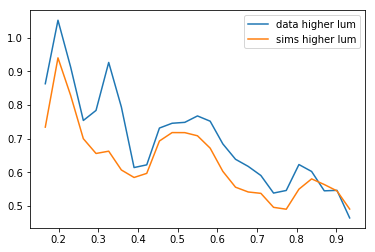

In [336]:
import h5py
import numpy as np
xx = 10
mastercat_v = '12_3_19'

path_mastercat = '/project/projectdirs/des/www/y3_cats/Y3_mastercat_'+mastercat_v+'.h5'
path_to_save = '/global/cscratch1/sd/mgatti/clustering_z/data/'


mastercat = h5py.File(path_mastercat,'r')
zspec_mstf = np.array(mastercat['catalog']['redmagic']['higherlum']['zspec'])
zrmg_mstf = np.array(mastercat['catalog']['redmagic']['higherlum']['zredmagic'])
zrmg_mst= (zrmg_mstf[zspec_mstf>-1])
zspec_mst = (zspec_mstf[zspec_mstf>-1])

#z_mag= [i[3] for i in (mastercat['catalog']['redmagic']['combined_sample_fid']['mag'])]
#z_mag = np.array(z_mag)
#z_mag_sub = z_mag[zspec_mstf>-1]

edg = np.linspace(0.15,0.95,26)
cntr = 0.5*(edg[1:]+edg[:-1])
edg_hr = np.linspace(0.,1.5,201)
cntr_hr = 0.5*(edg_hr[1:]+edg_hr[:-1])
corr = np.zeros(25)
corr1 = np.zeros(25)
for i in range(25):
    mask1 = (zrmg_mst>edg[i]) & ((zrmg_mst<edg[i+1]))
    #mask1 = (zspec_mst>edg[i]) & ((zspec_mst<edg[i+1]))
    
    
    
    #maskz_sub = (zrmg_mst>edg[i]) & (zrmg_mst<edg[i+1])
    #maskz = (zrmg_mstf>edg[i]) & (zrmg_mstf<edg[i+1])
    #ww1= match_distribution(z_mag[maskz],z_mag_sub[maskz_sub], 40)
    
    
    nzh1,_ = np.histogram(zspec_mst[mask1],bins=edg_hr,normed=True)
    
    #nzh,_ = np.histogram(zspec_mst[mask1],weights=ww1,bins=edg_hr,normed=True)
    nzh_u,_ = np.histogram(np.linspace(edg[i],edg[i+1],50000),bins=edg_hr,normed=True)
    #if i==xx:
        #plt.plot(cntr_hr,nzh)
    #corr[i] = np.trapz(nzh**2,cntr_hr)/np.trapz(nzh_u**2,cntr_hr)#
    corr1[i] = np.trapz(nzh1**2,cntr_hr)/np.trapz(nzh_u**2,cntr_hr)#
corr_data = np.sqrt(corr1)
#corr_dataw = np.sqrt(corr)
plt.plot(cntr,corr_data,label='data higher lum')
#plt.plot(cntr,corr_dataw,label='data higher lum w')









path_to_save = '/global/cscratch1/sd/mgatti/clustering_z/data/'
version = 'v1.9.8_Y3a'
mastercat_sims = h5py.File('/global/cscratch1/sd/jderose/BCC/Chinchilla/Herd/Chinchilla-3/sampleselection/Y3a/Buzzard-3_'+version+'_mastercat.h5','r')


# load redshifts into memory for subsequent tests *******************

zredmagic_tot = np.array(mastercat_sims['catalog']['redmagic']['higherlum']['zredmagic'])
zspec_tot = np.array(mastercat_sims['catalog']['redmagic']['higherlum']['zspec'])
mag = np.array(mastercat_sims['catalog']['redmagic']['higherlum']['zmag'])#.keys()

import timeit
corr1 = np.zeros(25)
for i in range(25):

    st0 = timeit.default_timer()
    mask1 = (zredmagic_tot>edg[i]) & ((zredmagic_tot<edg[i+1]))

    st = timeit.default_timer()
    
    nzh,_ = np.histogram(zspec_tot[mask1],bins=edg_hr,normed=True)
    
    end = timeit.default_timer()
    
    nzh_u,_ = np.histogram(np.linspace(edg[i],edg[i+1],50000),bins=edg_hr,normed=True)
    if i==xx:
        #plt.plot(cntr_hr,nzh,label='sims higher lum')
        xm = (edg[i+1] +edg[i])*0.5
    corr1[i] = np.trapz(nzh**2,cntr_hr)/np.trapz(nzh_u**2,cntr_hr)#
corr_sims_hr = np.sqrt(corr1)
plt.plot(cntr,corr_sims_hr,label='sims higher lum')
plt.legend()


path_to_save = '/global/cscratch1/sd/mgatti/clustering_z/data/'
save_obj(path_to_save+'/corr_bias_n2',[corr_sims_hr,corr_data])





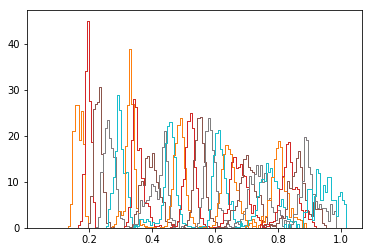

In [326]:
for i in range(25):
    maskz_sub = (zrmg_mst_sub>edg[i]) & (zrmg_mst_sub<edg[i+1])
    maskz = (zrmg_mst>edg[i]) & (zrmg_mst<edg[i+1])
    _=plt.hist(zspec_mst[maskz],normed=True,histtype='step',bins=np.linspace(edg[i]-0.1,edg[i]+0.1,30))
    _=plt.hist(zspec_mst_sub[maskz_sub],normed=True,histtype='step',label='sub',bins=np.linspace(edg[i]-0.1,edg[i]+0.1,30))
    #plt.legend()
    #plt.show()

In [332]:
z_mag[maskz]#,z_mag_sub[maskz_sub]

array([17.523615, 17.134647, 17.196999, ..., 16.67053 , 17.390003,
       16.635256], dtype=float32)

In [285]:
def match_distribution(z1, z2, z_bins):
    
    rhist, rbins = np.histogram(z1, bins=z_bins, normed=True)
    rhist_s, rbins_s = np.histogram(z2, bins=z_bins, normed=True)
    cumul_weight = np.zeros(len(rhist))
    cumul_weight1 = np.zeros(len(rhist))
    inds = np.digitize(z2, rbins)
    probr = np.zeros(len(z2))
    for n in range(z2.size):
        if ((inds[n]>0.) & (inds[n]<len(rhist))):
            if (rhist[inds[n] - 1]) / (rhist_s[inds[n] - 1]) != np.inf:
                if (rhist[inds[n] - 1]) / (rhist_s[inds[n] - 1]) != np.nan:
                    probr[n] = (rhist[inds[n] - 1]) / (rhist_s[inds[n] - 1])

    for n in range(z2.size):
        if ((inds[n] > 0.) & (inds[n] < len(rhist))):
            if (rhist[inds[n] - 1]) / (rhist_s[inds[n] - 1]) != np.inf:
                if (rhist[inds[n] - 1]) / (rhist_s[inds[n] - 1]) != np.nan:
                    cumul_weight[inds[n]]+=probr[n]
    for i in range(len(rhist)):
        cumul_weight1[i]=(rhist[i]) / (rhist_s[i])
    return probr / float(probr.sum())
    
    #return np.ones(len(z1))


In [305]:
ww1= match_distribution( z_mag_sub[maskz_sub],z_mag[maskz], 10)
ww1

/global/u2/m/mgatti/.conda/envs/myenv_up/lib/python2.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  This is separate from the ipykernel package so we can avoid doing imports until
/global/u2/m/mgatti/.conda/envs/myenv_up/lib/python2.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  after removing the cwd from sys.

array([3.90760578e-05, 0.00000000e+00, 0.00000000e+00, ...,
       6.18267261e-06, 0.00000000e+00, 0.00000000e+00])

In [334]:
for i in range(25):
    maskz_sub = (zrmg_mst>edg[i]) & (zrmg_mst<edg[i+1])
    maskz = (zrmg_mst>edg[i]) & (zrmg_mst<edg[i+1])
    ww1= match_distribution(z_mag[maskz],z_mag_sub[maskz_sub], 40)
    _=plt.hist(z_mag[maskz],normed=True,histtype='step',bins=np.linspace(15,23,50))
    _=plt.hist(z_mag_sub[maskz_sub],normed=True,histtype='step',label='sub',bins=np.linspace(15,23,50))
    _=plt.hist(z_mag_sub[maskz_sub],weights = ww1,normed=True,histtype='step',label='sub match',bins=np.linspace(15,23,50))
    plt.legend()
    plt.show()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 2686519 but corresponding boolean dimension is 46185

In [270]:
version = 'v1.9.8_Y3a'
mastercat = h5py.File('/global/cscratch1/sd/jderose/BCC/Chinchilla/Herd/Chinchilla-3/sampleselection/Y3a_old/Buzzard-3_'+version+'_mastercat.h5','r')


IOError: Unable to open file (unable to open file: name = '/global/cscratch1/sd/jderose/BCC/Chinchilla/Herd/Chinchilla-3/sampleselection/Y3a_old/Buzzard-3_v1.9.8_Y3a_mastercat.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

# rerun Marco

In [256]:
len(lum_mst)

497733

In [426]:
import sys

sys.path.insert(0, '/global/homes/g/giannini/clustering-z/WZ_utils/')
from covariance_routines import *
from load_routines import *

n_jck=100
gamma = 1
zmin=0.15
zmax=0.95
bins = 25
ang_bins = 8
info ={'n_jck':n_jck,'zmin':zmin,'zmax':zmax,'bins' : bins}

path_base = '/global/cscratch1/sd/mgatti/clustering_z/cross_corr_'

to_read = ['rmgz_higherlum/',
           'rmgz_highlum/',
           'rmgz/',
           'truez_higherlum/',
           'truez_highlum/',
           'truez/',
           'truez_1500_5000kpc/',
           'rmgz_1500_5000kpc/',
]


to_read = ['truez_highlum/']

measured_wz = load_obj('/global/homes/m/mgatti/clustering-z/WZ_cosmosis1')


            

    
    
runs = dict()
for ff in to_read:
    try:
         dictionary = read_results_fast(path_base+ff,n_jck,gamma,ang_bins)
         method = ff.strip('/')
         print (method)
         runs[method]  = WZ_obj(dictionary,info)
         
         runs[method].set_wdm(np.hstack([measured_wz['th_correction'],0]))
         runs[method].set_sompz(nz_sompz_25bins)
         runs[method].shrink_z_interval(xd=0,xup=1)
         runs[method].compute_Xsigma_sompz(nz_sompz_25bins)
         runs[method].compute_nz(estimators = ['y1','wdm_br','wdm','wdm_brcorr'])
         runs[method].compute_mean_std()
            
        '''
        runs[method].Nz_mean[estimator][tomobin],runs[method].Nz_mean_err[estimator][tomobin]

        '''
    except:
        print (path_base+ff)



/global/cscratch1/sd/mgatti/clustering_z/cross_corr_truez_highlum/


In [428]:
π

KeyError: 'truez_1500_5000kpc'